In [1]:
pip install transformers==3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.0/97.0 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 754.6/754.6 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 34.8 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [48 lines of output]
      /tmp/pip-build-env-25cb00m0/overlay/lib/python3.10/site-packages/setuptools/dist.py:318: InformationOnly: Normalizing '0.8.0.rc4' to '0.8.0rc4'
        self.metadata.version = self._normalize_version(self.metadata.version)
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.linux-x86_64-cpython-310
      creati

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

In [32]:
df = pd.read_csv('/Corona_NLP_train.csv', encoding = 'latin-1')
# df=df[:2000]
df.shape

(2000, 6)

In [33]:
# Let's have a look at the class balance.
# sns.countplot(df.Sentiment)
# plt.xlabel('review score');

In [34]:
# Function to convert score to sentiment
def to_sentiment(rating):
    
    if(rating=='Neutral'):
        return 2
    elif rating=='Positive':
        return 3
    elif rating=='Extremely Positive':
        return 4
    elif rating=='Negative':
        return 1
    elif rating=='Extremely Negative':
        return 0

# Apply to the dataset 
df['sentiment'] = df.Sentiment.apply(to_sentiment)

In [35]:
# Plot the distribution
# class_names = ['Extremely negative', 'Negative','Neutral', 'Positive','Extremely Positive']
# ax = sns.countplot(df.sentiment)
# plt.xlabel('review sentiment')
# ax.set_xticklabels(class_names)

In [36]:
# Set the model name
MODEL_NAME = 'bert-base-cased'

# Build a BERT based tokenizer
# tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [37]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set 


[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [38]:
# Store length of each review 
token_lens = []

# Iterate through the content slide
for txt in df.OriginalTweet:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 0, 'Token count')

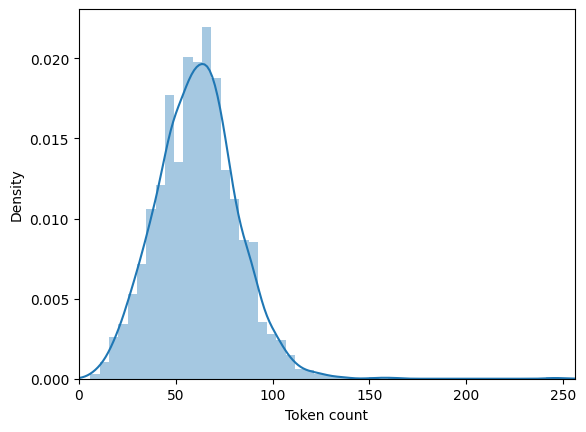

In [39]:
# plot the distribution of review lengths 
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

In [40]:
MAX_LEN = 160
RANDOM_SEED=42
device='cpu'

In [41]:
class GPReviewDataset(Dataset):
    # Constructor Function 
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # Length magic method
    def __len__(self):
        return len(self.reviews)
    
    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # Encoded format to be returned 
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [42]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(1600, 7) (200, 7) (200, 7)


In [43]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.OriginalTweet.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [44]:
# Create train, test and val data loaders
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [45]:
# Examples 
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [46]:
# Load the basic BERT model 
bert_model = BertModel.from_pretrained(MODEL_NAME)

In [82]:
# Build the Sentiment Classifier class 
class SentimentClassifier(nn.Module):
    
    # Constructor class 
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.lstm = nn.LSTM(self.bert.config.hidden_size,
                           hidden_size=384,
                           num_layers=10,
                           dropout=0.45,
                           bidirectional=True)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
#         pooled_output=outputs[1]
#         #  Add a dropout layer 
#         output = self.drop(pooled_output)
#         return self.out(output)
    
        bert_output = outputs[0]  # BERT embeddings
        
        # Pass BERT embeddings through LSTM
        lstm_output, _ = self.lstm(bert_output)
        
        # Apply dropout and pass through linear layer
        lstm_output = self.drop(lstm_output)
        logits = self.out(lstm_output[:, -1, :])  # Using only the last timestep output of LSTM
        
        return logits

In [83]:
# Instantiate the model and move to classifier
model = SentimentClassifier(len(class_names))
model = model.to('cpu')

In [84]:
# Number of hidden units
print(bert_model.config.hidden_size)

768


In [85]:
# Number of iterations 
EPOCHS = 10

# Optimizer Adam 
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

In [86]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # Backward prop
        loss.backward()
        
        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [87]:
from tqdm import tqdm

# Function for a single training iteration with tqdm
def train_epoch_with_progress_bar(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    # Initialize tqdm
    with tqdm(total=len(data_loader), desc="Training") as pbar:
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            targets = batch["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

            # Backward prop
            loss.backward()

            # Gradient Descent
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            
            # Update tqdm progress bar
            pbar.update(1)
            pbar.set_postfix({'loss': loss.item()})
    
    return correct_predictions.double() / n_examples, np.mean(losses)


In [88]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

In [89]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    
    # Show details 
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    
    train_acc, train_loss = train_epoch_with_progress_bar(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    
    print(f"Train loss {train_loss} accuracy {train_acc}")
    
    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # If we beat prev performance
    if val_acc > best_accuracy:
#         torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/1
----------


Training: 100%|██████████| 100/100 [32:16<00:00, 19.36s/it, loss=1.56]


Train loss 1.586308504343033 accuracy 0.25375
Val   loss 1.5904046297073364 accuracy 0.22

CPU times: user 1h 5min, sys: 1min 42s, total: 1h 6min 43s
Wall time: 33min 31s
